# Import

In [1]:
from  functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate
import matplotlib.pyplot as plt
from plot import *
set_things()
linestyles()

'blue','-',''
'red','-',''
'green','-',''
'purple','-',''
'brown','-',''


# Loading excel files

In [3]:
# population
US_State_Data = pd.read_excel (r'USA_Data.xlsx')

#loading population of states
State_pop=(US_State_Data.take([3],axis=1).T).to_numpy()
US_State_pop=[]
for i in State_pop:
    US_State_pop.append(i)

statewise_pop = {}

State_name=(US_State_Data.take([0],axis=1).T).to_numpy()

for i in range(len(State_pop[0])):
    statewise_pop.update({State_name[0][i]:State_pop[0][i]})


# loading coordinates of states
State_coo=(US_State_Data.take([4,5],axis=1).T).to_numpy()
US_State_coo=[]
for i in State_coo:
    US_State_coo.append(i)

#Loading no of cases in US
US_cases = pd.read_excel (r'state_cases_day.xlsx')
UnitedState_cases=(US_cases.take([2],axis=1).T).to_numpy()


# Model

In [4]:
class Multi_SEIR():
    def __init__(self,sub_population_num,l1=None):
        self.n_population = sub_population_num
        self.y = None
        if type(l1)==type([]):
            X0,W0,Y0,Z0,D0 = l1
        else:
            X0 = np.ones((sub_population_num,sub_population_num))*1000
            W0 = np.zeros((sub_population_num,sub_population_num))
            Y0 = np.ones((sub_population_num,sub_population_num))*1
            Z0 = np.zeros((sub_population_num,sub_population_num))
            D0 = np.zeros((sub_population_num,sub_population_num))
        y0 = np.hstack([X0.ravel(),W0.ravel(),Y0.ravel(),Z0.ravel(),D0.ravel()])
        self.y0 = y0
        self.diff = {'X_d':[], 'W_d':[], 'Y_d':[], 'Z_d':[], 'D_d':[],}
        self._spacer = '\n'
    
    def sumit(self,t,y,fs,*args,**kwargs):
        s = np.zeros(self.n_population*self.n_population)
        for i in fs:
            s += i(t,y,self.y,**kwargs)
        return s
    
    def solve(self,t,**kwargs):
        def system(y,t):
            ret = np.hstack([self.sumit(t,y,self.diff[k]) for k in self.diff])
            return ret.ravel()
        args = ()
        self.y = scipy.integrate.odeint(system,self.y0,t,args=args,**kwargs)
    
    def __repr_text(self,text):
        return (self._spacer+text)
    
    def __repr__(self):
        t = self.__repr_text
        text = t("Multi-SEIR model with following parameters:")
        text += t("Total number of sub population: {}".format(self.n_population))
        self._spacer = "\n"
        text += t("Initial conditions: ")
        
        self._spacer = "\n\t"
        n = self.n_population*self.n_population
        names = list(self.diff.keys())
        for i in range(5):
            text += t("{}: ".format(names[i])+self.y0[i*n:i*n+n].reshape(self.n_population,self.n_population).__repr__())

        self._spacer = "\n\n"
        text += t("Transitions:")
        for k,v in self.diff.items():
            self._spacer = "\n\t\n"
            text += t("{}: ".format(k))
            self._spacer = "\n\t\t"
            text += t("{}".format(v))
        
        if type(self.y)!=type(None):
            for i in range(5):
                text += t("{}: ".format(names[i])+self.y[-1][i*n:i*n+n].reshape(self.n_population,self.n_population).__repr__())
            
        return text
    
    def add(self,name,fs):
        if type(fs)!=type([]):
            fs = [fs]
        for f in fs:
            self.diff[name] += [partial(f,dim=self.n_population)]
            

# Initial conditions

In [6]:
dim = len(statewise_pop)
X0 = np.zeros((dim,dim))
W0 = np.zeros((dim,dim))
Y0 = np.zeros((dim,dim))
Z0 = np.zeros((dim,dim))
D0 = np.zeros((dim,dim))

for ii in range(len(State_name[0])):
    Y0[ii,ii]=UnitedState_cases[0][32*ii]
    
W0=2*Y0

# Defining some arrays and importing files

In [7]:
#State captial coordinate array
dist_l=[]

for i in range(len(US_State_coo[0])):
    dist_l.append([US_State_coo[0][i],US_State_coo[1][i]])

#State array
l2=[]
for i in range(len(State_name[0])):
    l2.append(State_name[0][i])

#Importing R0 for 1st cycle (1st 2 weeks)
import pickle
with open('./R0_week1.dict','rb') as file:
    R0_dict1 = pickle.load(file)

R01 = [ R0_dict1[l2[i]] for i in range(len(l2))]

#Importing R0 for 2nd cycle (2nd and third week)
import pickle

with open('./R0_week2.dict','rb') as file:
    R0_dict2 = pickle.load(file)

R02 = [ R0_dict2[l2[i]] for i in range(len(l2))]

#defining dictionary for no of cases
no_of_cases={}
for i in range(len(l2)):
    no_of_cases.update({'{}'.format(l2[i]):[UnitedState_cases[0][32*i:32*(i+1)]]})

# Defining some functions

In [8]:
def make_x0(l2,statewise_pop):
    x = np.zeros((len(l2),len(l2)))
    for j in range(len(l2)):
        row = []
        for i in range(len(l2)):
            if i==j:
                row += [0]
            else:
                row += [statewise_pop[l2[i]]]
        row = np.array(row)
        row = row/row.sum()
        row[j] = 9
        row *= 0.1*statewise_pop[l2[j]]
        x[j:] = row
    return x

from math import radians, cos, sin, asin, sqrt 
def distance(lat1, lat2, lon1, lon2): 
      
    # The math module contains a function named 
    # radians which converts from degrees to radians. 
    lon1 = radians(lon1) 
    lon2 = radians(lon2) 
    lat1 = radians(lat1) 
    lat2 = radians(lat2) 
       
    # Haversine formula  
    dlon = lon2 - lon1  
    dlat = lat2 - lat1 
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
  
    c = 2 * asin(sqrt(a))  
     
    # Radius of earth in kilometers. Use 3956 for miles 
    r = 6371

    ret = c*r
    if ret==0:
        ret = 100
    return ret

def make_x01(dist_l,statewise_pop):
    x = np.zeros((len(l2),len(l2)))
    for i in range(len(l2)):
        lat1, lon1 = dist_l[i]
        for j in range(len(l2)):
            lat2, lon2 = dist_l[j]
            if i!=j:
                x[i,j] = 1/distance(lat1, lat2, lon1, lon2)
    x = x/x.sum(axis=1).reshape(-1,1)
    for i in range(len(x)):
        x[i,i] = 9
        x[i,:] *= 0.1*statewise_pop[l2[i]] 
    return x

X0 = 0.5*make_x0(l2,statewise_pop) + 0.5*make_x01(dist_l,statewise_pop)

# Transition

In [9]:
def f(t,y,y_,B=0,sign=1,dim=1):
    n = dim*dim
    X,W,Y,Z,D = [y[i*n:i*n+n].reshape(dim,dim) for i in range(5)]
    N = X+Y+W+Z
    ret =  sign*B*X*(Y.sum(axis=1)/N.sum(axis=1)).reshape(-1,1)
    return ret.ravel()

def g(t,y,y_,sig=0,sign=1,dim=1):
    n = dim*dim
    X,W,Y,Z,D = [y[i*n:i*n+n].reshape(dim,dim) for i in range(5)]
    ret = sign*sig*W
    return ret.ravel()

def h(t,y,y_,gam=0,rho=0,sign=1,dim=1):
    n = dim*dim
    X,W,Y,Z,D = [y[i*n:i*n+n].reshape(dim,dim) for i in range(5)]
    ret = sign*gam*Y*(1-rho)
    return ret.ravel()

def q(t,y,y_,rho=0.01,sign=1,dim=1):
    n = dim*dim
    X,W,Y,Z,D = [y[i*n:i*n+n].reshape(dim,dim) for i in range(5)]
    ret = sign*rho*Y
    return ret.ravel()

def mobility(t,y,y_,which='X',l=0,r_f=0,C=0,sign=1,dim=1):
    n = dim*dim
    temp_dict = {}
    for k,v in zip(['X','W','Y','Z','D'],[y[i*n:i*n+n].reshape(dim,dim) for i in range(5)]):
        temp_dict[k] = v
    x = temp_dict[which]
    np.random.seed(int(t))
    r = r_f()
    ret = sign*C* ((-l.sum(axis=0)*(np.eye(dim)*np.diag(x)) + l*np.diag(x)) +
                  (+(r*x).sum(axis=0)*np.eye(dim) - r*x))
    return ret.ravel()     


# Running model for 1st cycle

In [12]:
B = np.array(R01)/3
sig = 1/7
gam = 1/3
rho = 0


C = 0.5
l = np.array([[0.]])
def R_f(dim=1):
    mat = 0.1*np.random.random((dim,dim))
    return (mat-np.eye(dim)*np.diag(mat))
r_f = partial(R_f,dim=dim)




model = Multi_SEIR(dim,[X0,W0,Y0,Z0,D0])  

model.add('X_d', [partial(f,B=B,sign=-1),
                  partial(mobility,l=l,r_f=r_f,which='X',C=C),
                    ])

model.add('W_d', [partial(f,B=B,sign=1),
                  partial(g,sig=sig,sign=-1),
                  partial(mobility,l=l,r_f=r_f,which='W',C=C),  ])

model.add('Y_d', [partial(g,sig=sig,sign=1),
                    partial(h,gam=gam,rho=rho,sign=-1),
                    partial(q,rho=rho,sign=-1),
                  partial(mobility,l=l,r_f=r_f,which='Y',C=C),
                    ])

model.add('Z_d', [partial(h,gam=gam,rho=rho,sign=1),
                   partial(mobility,l=l,r_f=r_f,which='Z',C=C),
                 ])

model.add('D_d', [partial(q,rho=rho,sign=1)])

days = 7
model.solve(range(days))

y0=model.y[-1]

# Running model for 2nd cycle

In [13]:
B = np.array(R02)/3


model1 = Multi_SEIR(dim)  
model1.y0=y0
model1.add('X_d', [partial(f,B=B,sign=-1),
                  partial(mobility,l=l,r_f=r_f,which='X',C=C),
                    ])

model1.add('W_d', [partial(f,B=B,sign=1),
                  partial(g,sig=sig,sign=-1),
                  partial(mobility,l=l,r_f=r_f,which='W',C=C),  ])

model1.add('Y_d', [partial(g,sig=sig,sign=1),
                    partial(h,gam=gam,rho=rho,sign=-1),
                    partial(q,rho=rho,sign=-1),
                  partial(mobility,l=l,r_f=r_f,which='Y',C=C),
                    ])

model1.add('Z_d', [partial(h,gam=gam,rho=rho,sign=1),
                   partial(mobility,l=l,r_f=r_f,which='Z',C=C),
                 ])

model1.add('D_d', [partial(q,rho=rho,sign=1)])

days = 193
model1.solve(range(days))

# Plotting statewise prediciton graphs

C:\Users\Sp.mmi\anaconda3\lib\site-packages\ipykernel_launcher.py:55: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\Sp.mmi\anaconda3\lib\site-packages\ipykernel_launcher.py:55: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\Sp.mmi\anaconda3\lib\site-packages\ipykernel_launcher.py:55: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\Sp.mmi\anaconda3\lib\site-packages\ipykernel_launcher.py:55: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\Sp.mmi\anaconda3\lib\site-packages\ipykernel_launcher.py:55: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a

C:\Users\Sp.mmi\anaconda3\lib\site-packages\ipykernel_launcher.py:55: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\Sp.mmi\anaconda3\lib\site-packages\ipykernel_launcher.py:55: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\Sp.mmi\anaconda3\lib\site-packages\ipykernel_launcher.py:55: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\Sp.mmi\anaconda3\lib\site-packages\ipykernel_launcher.py:55: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\Sp.mmi\anaconda3\lib\site-packages\ipykernel_launcher.py:55: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a

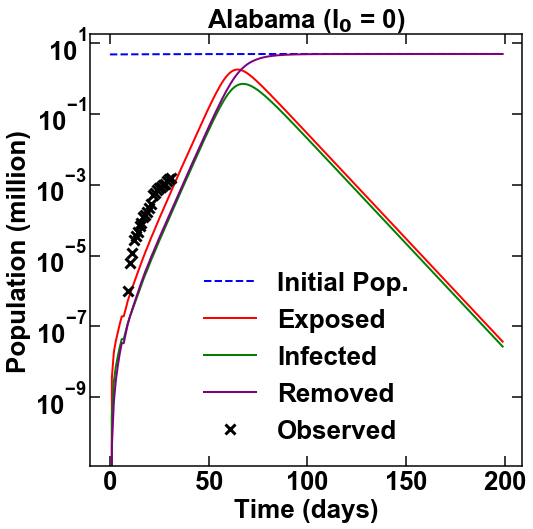

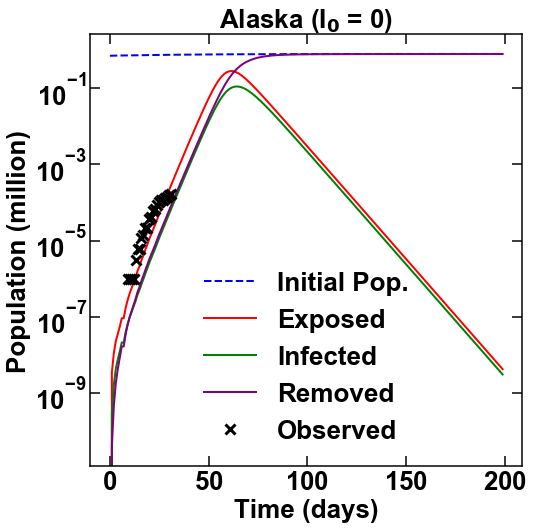

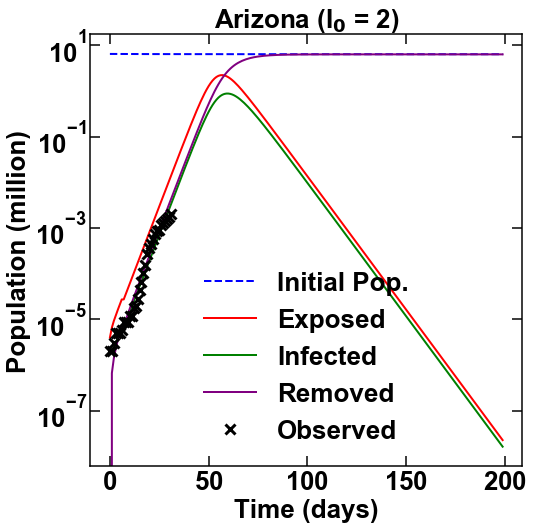

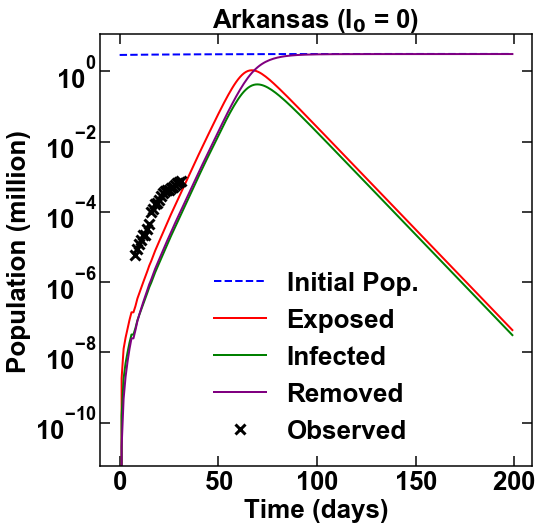

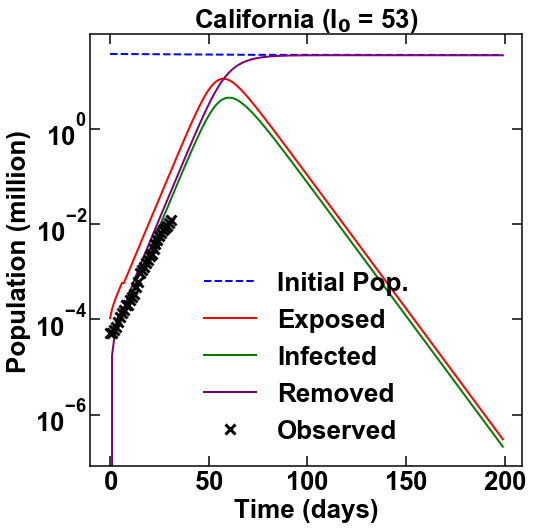

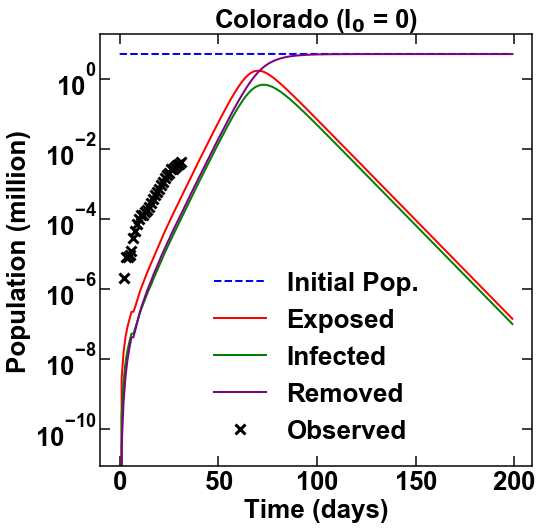

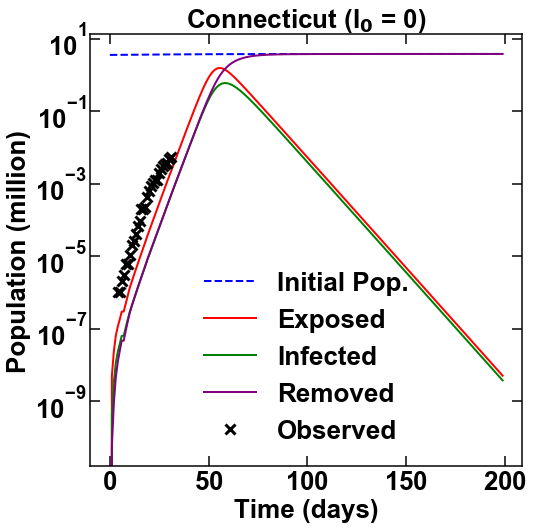

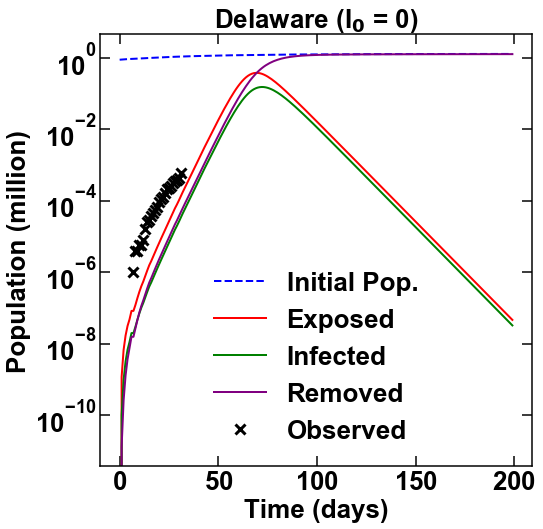

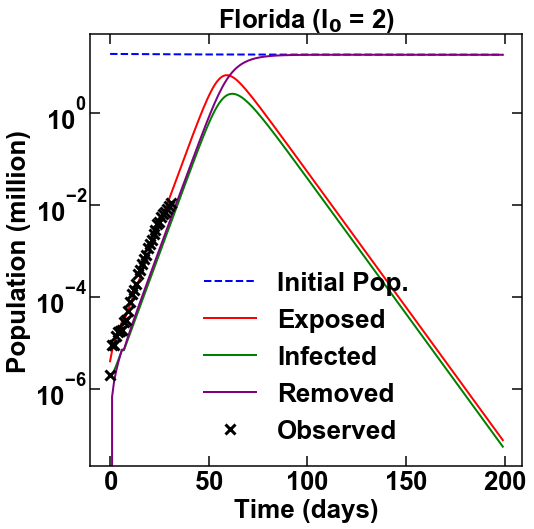

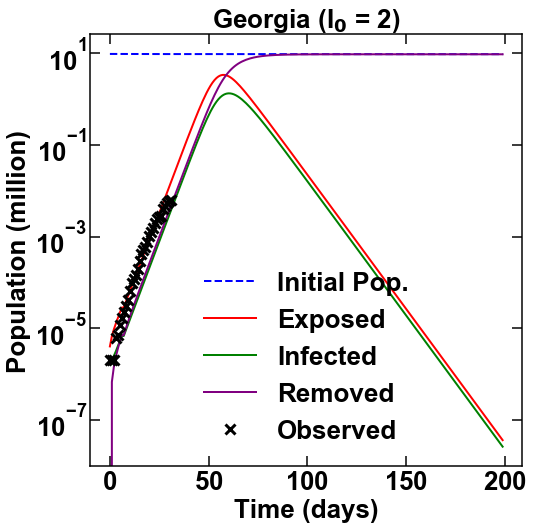

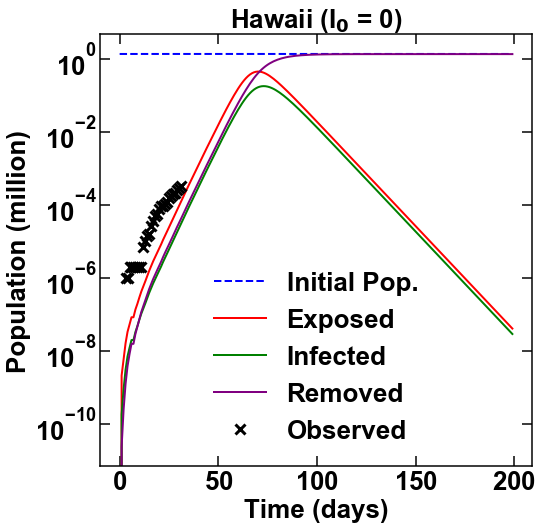

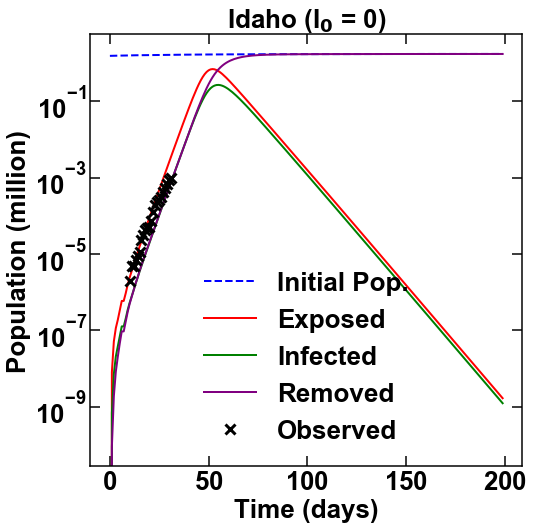

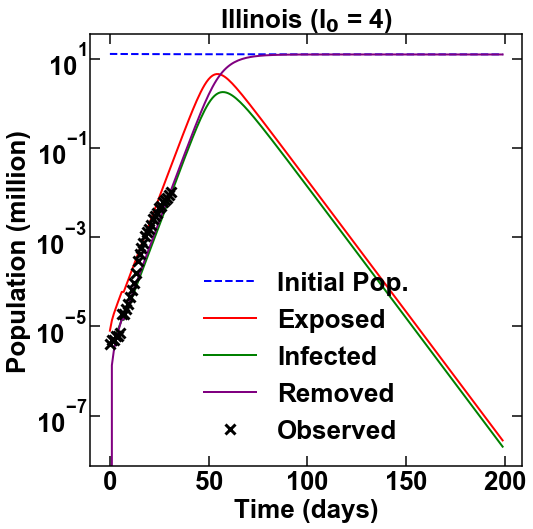

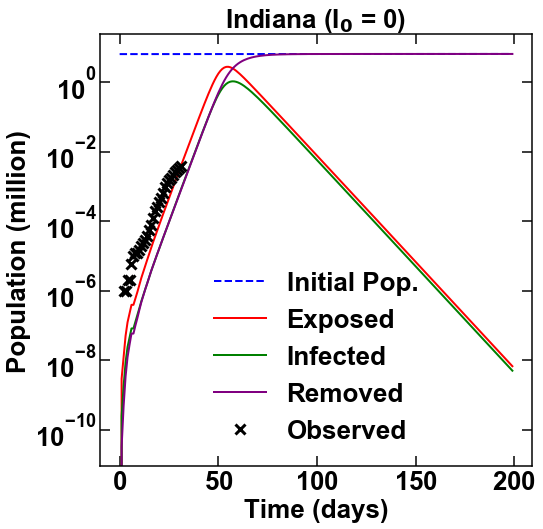

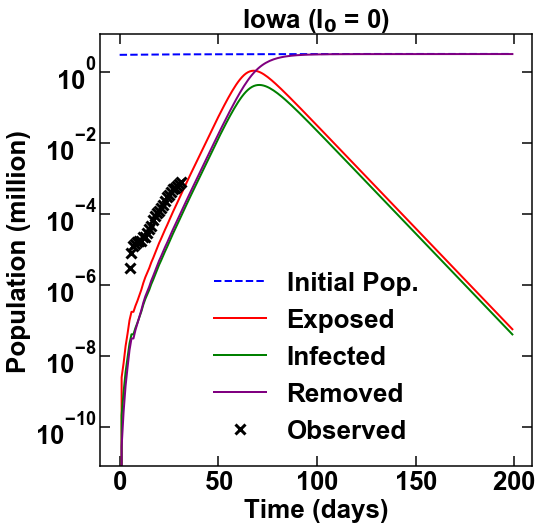

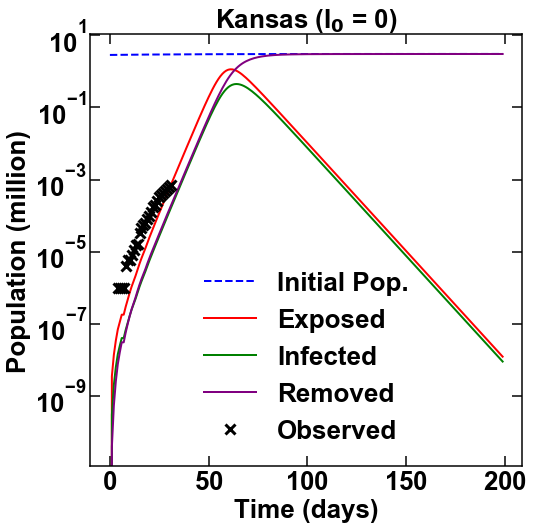

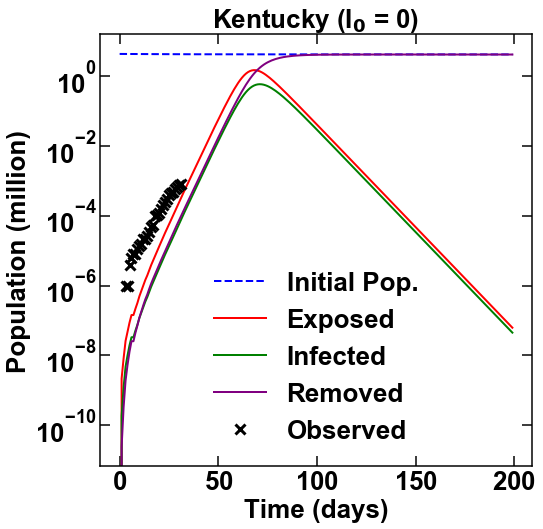

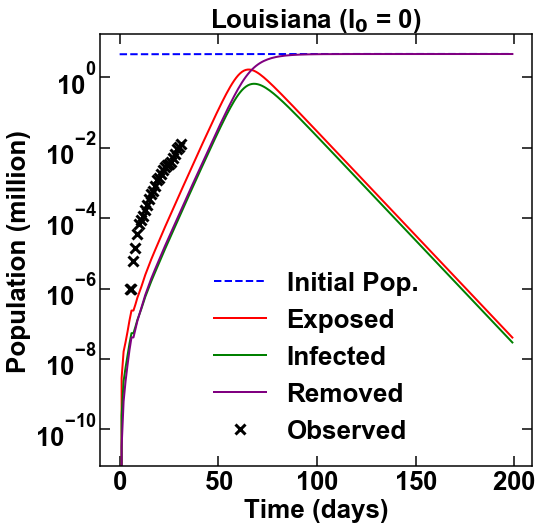

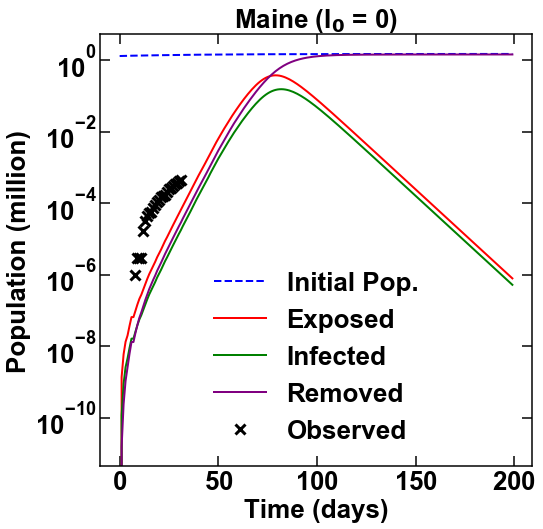

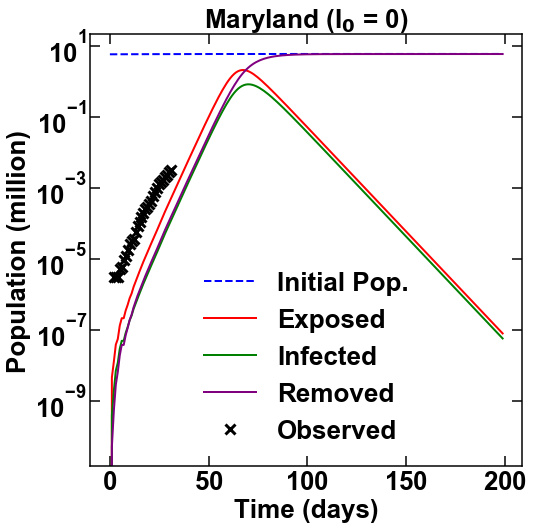

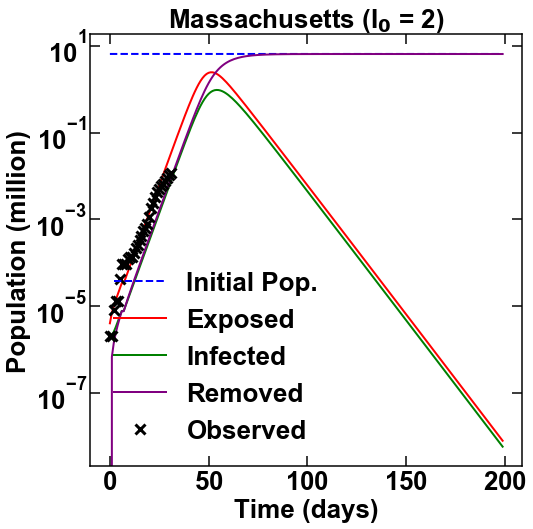

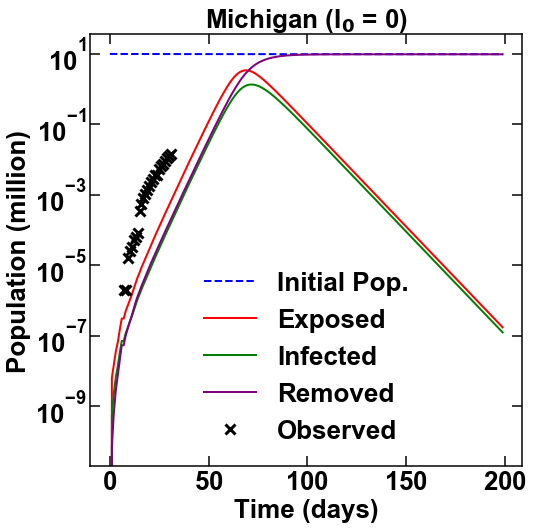

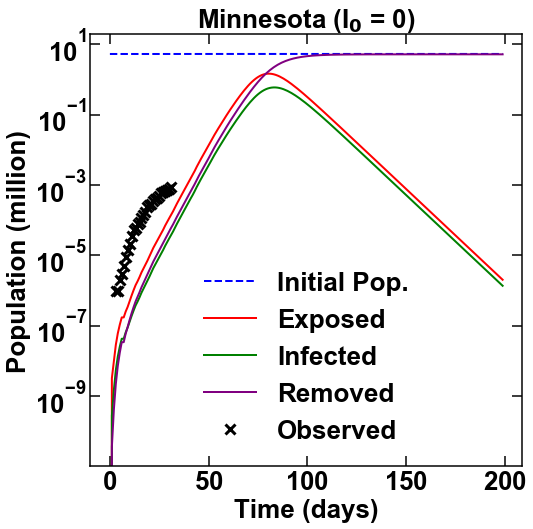

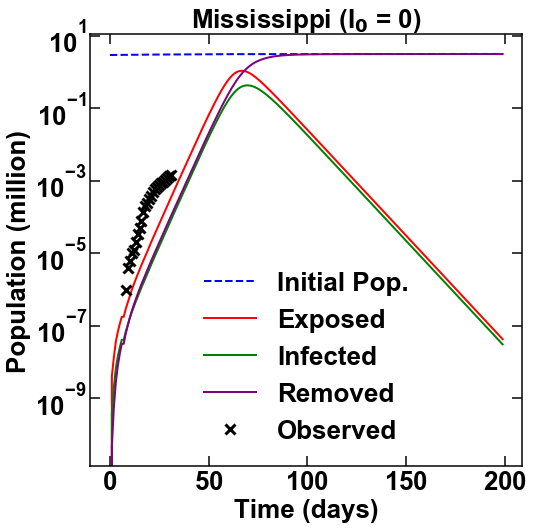

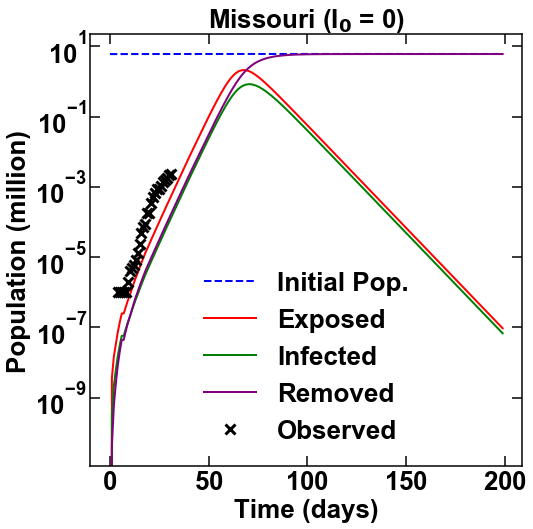

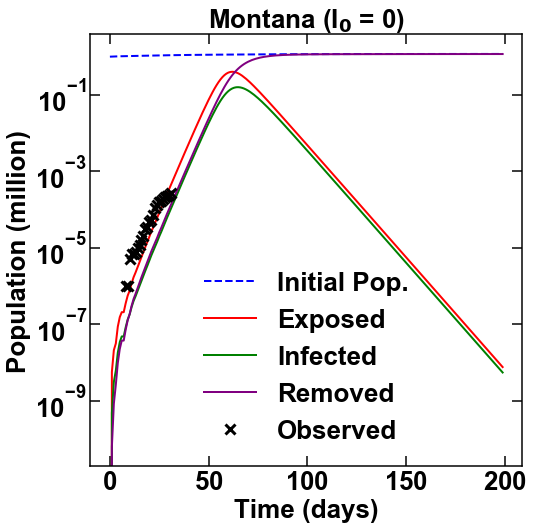

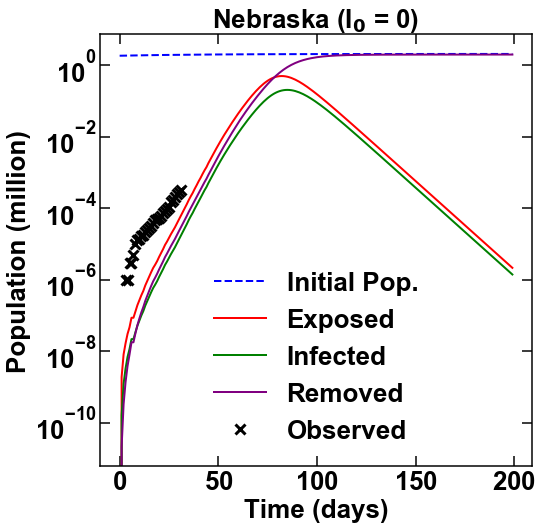

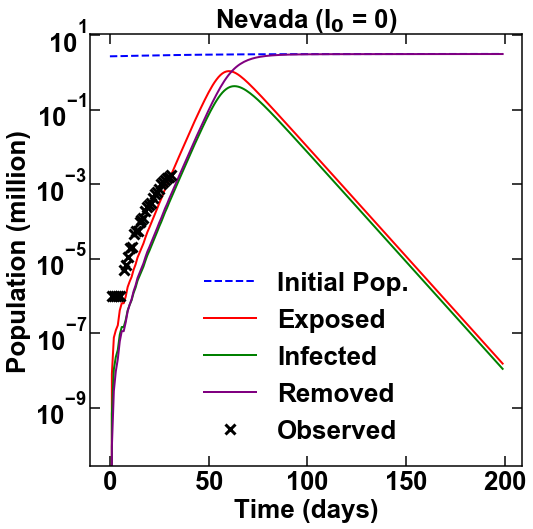

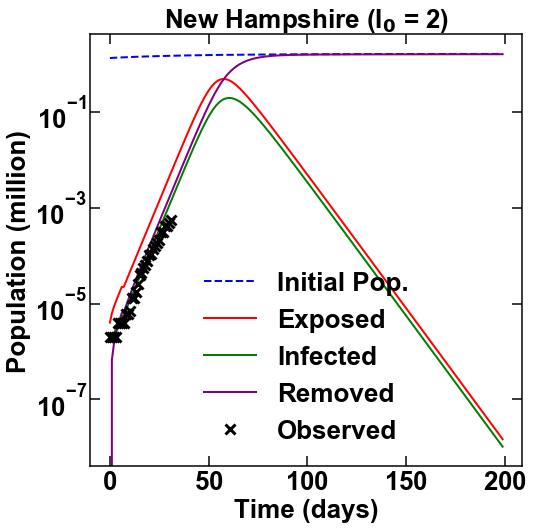

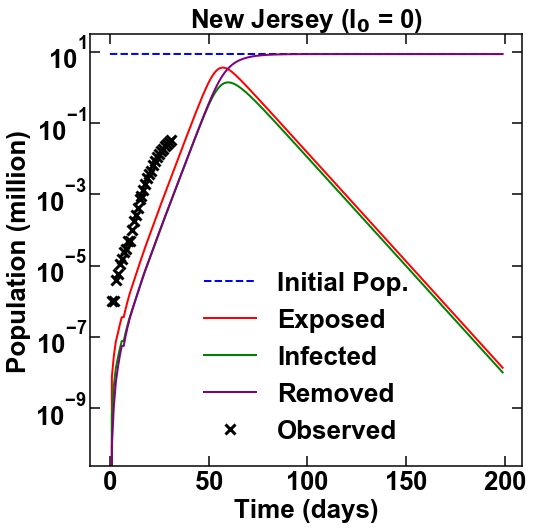

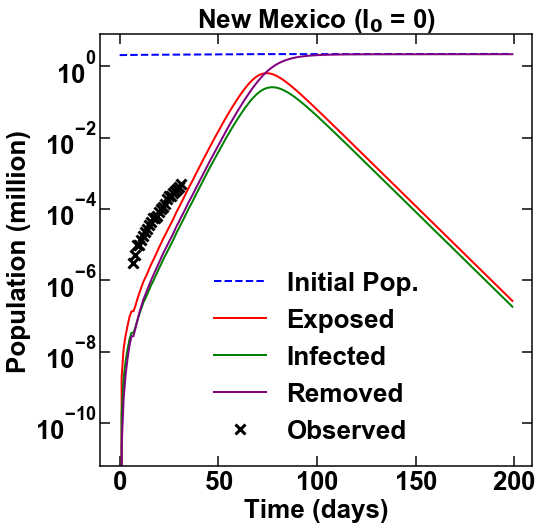

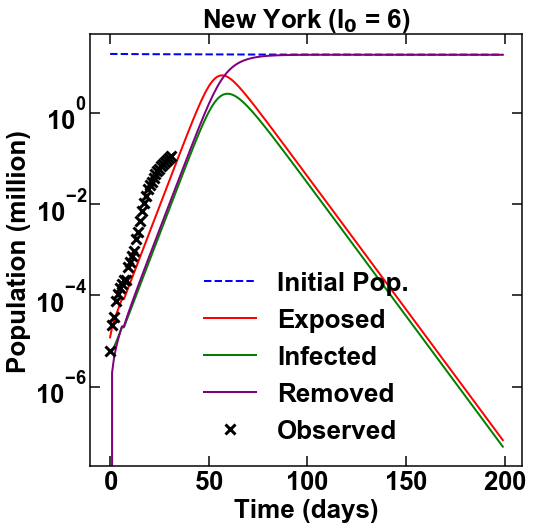

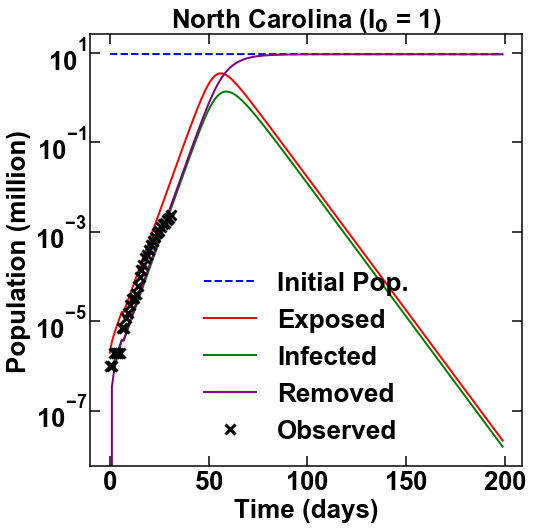

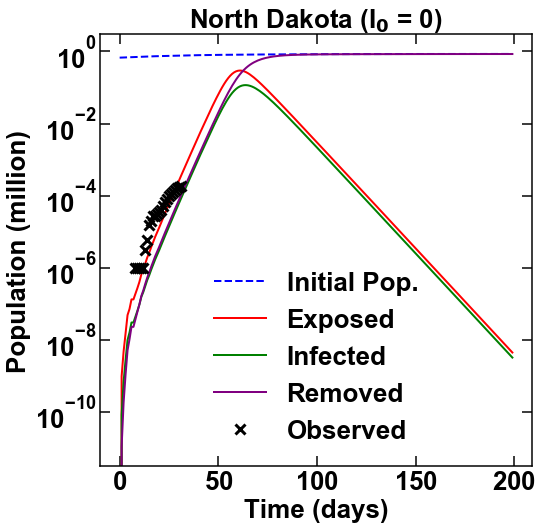

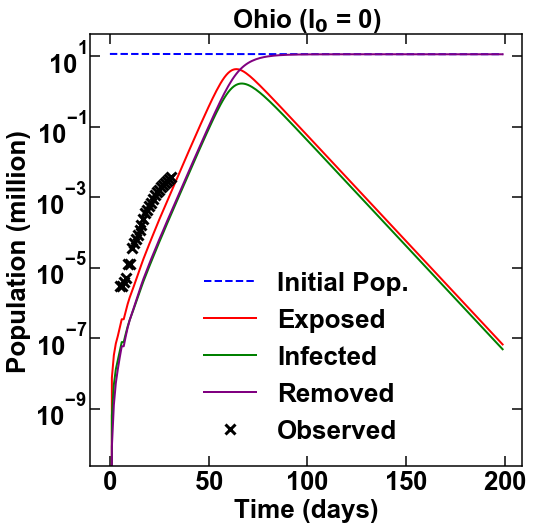

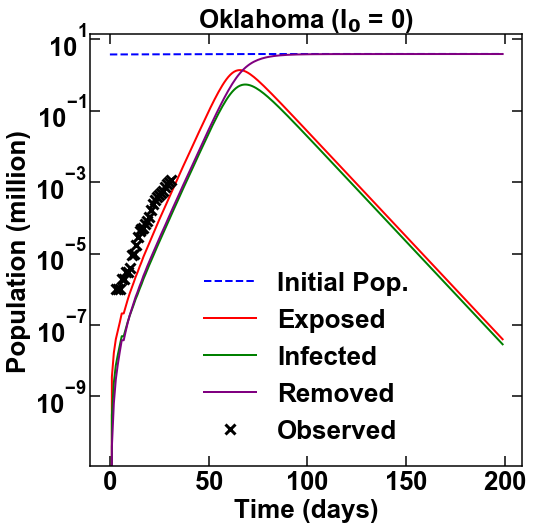

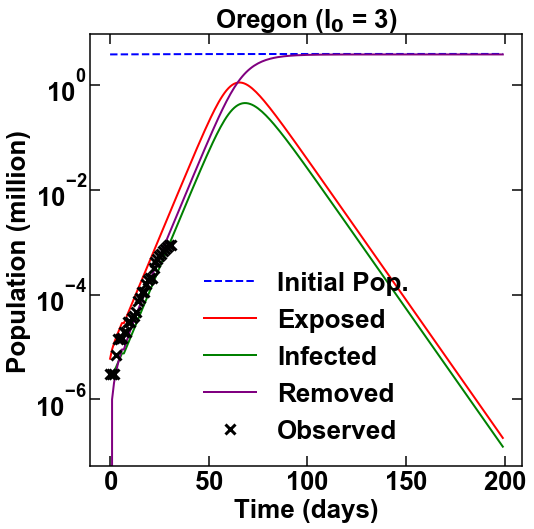

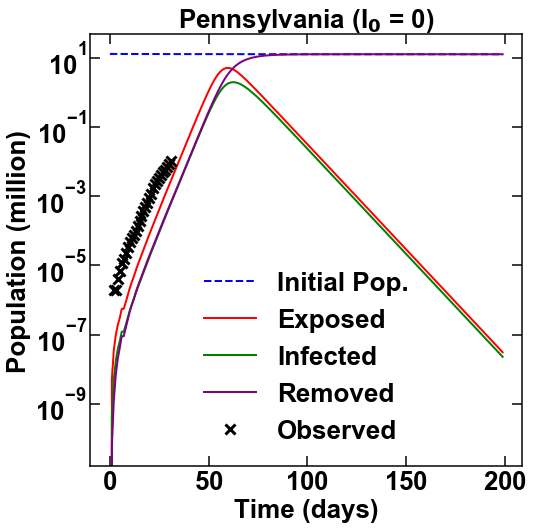

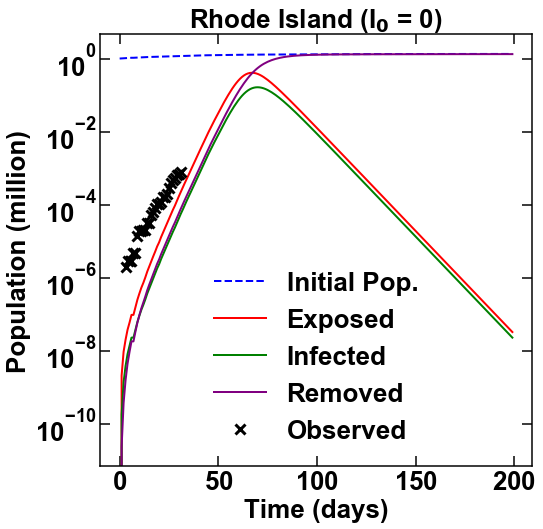

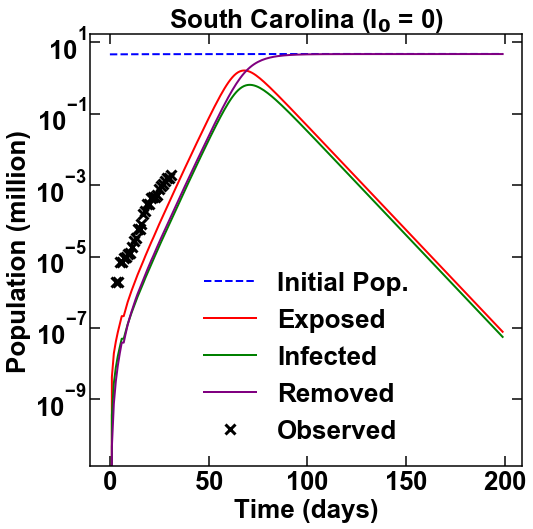

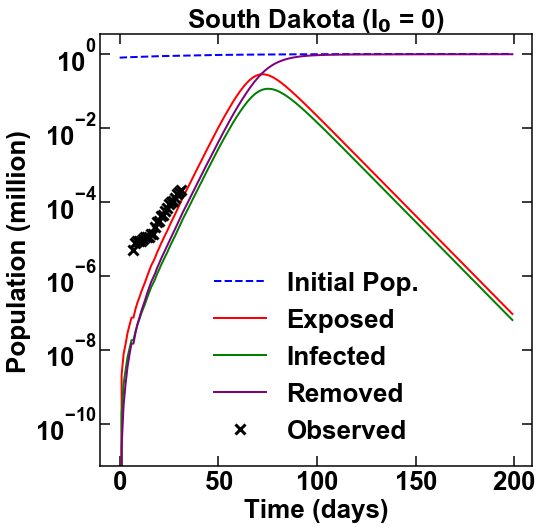

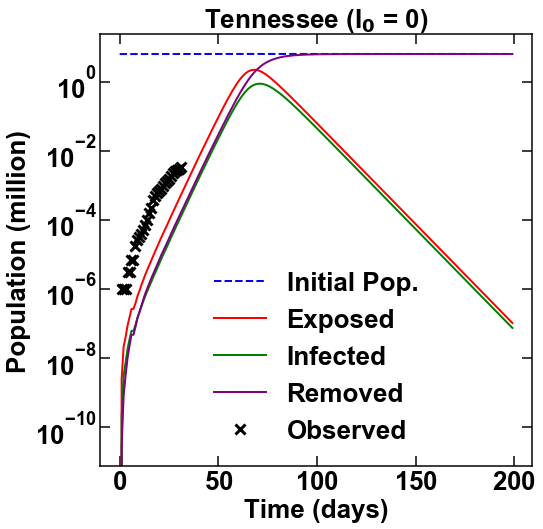

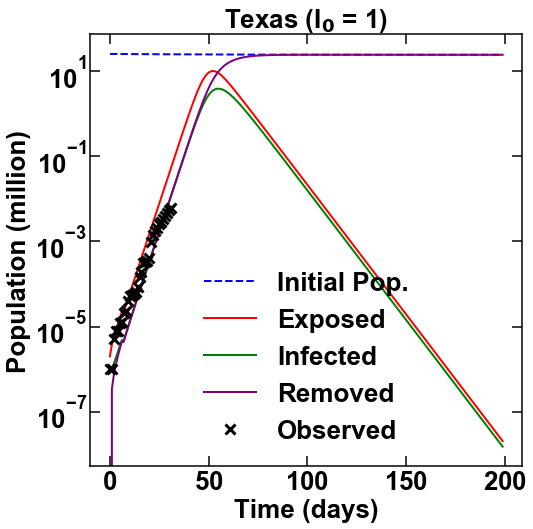

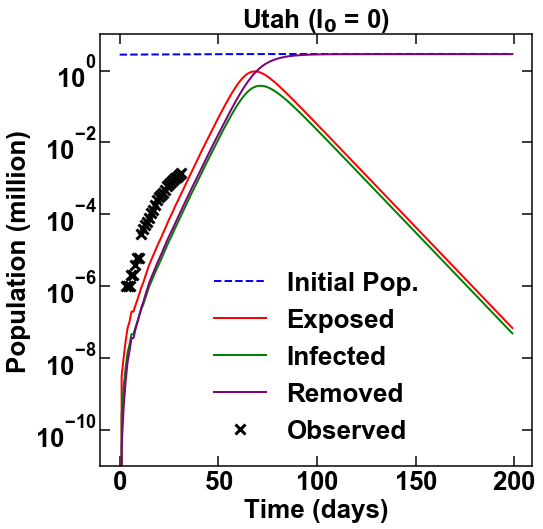

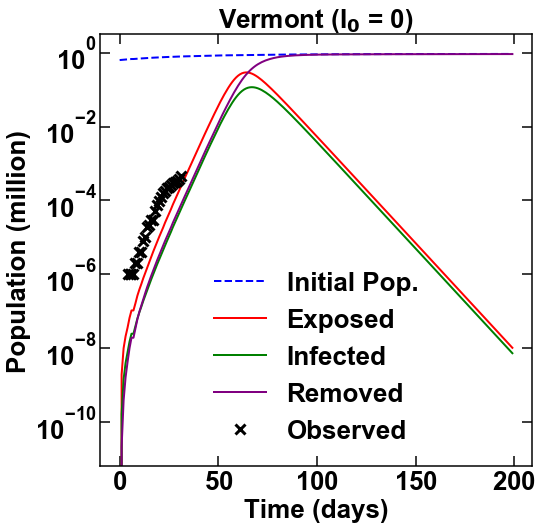

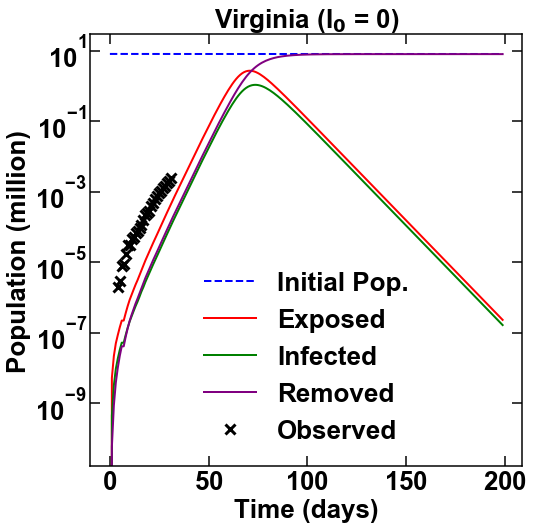

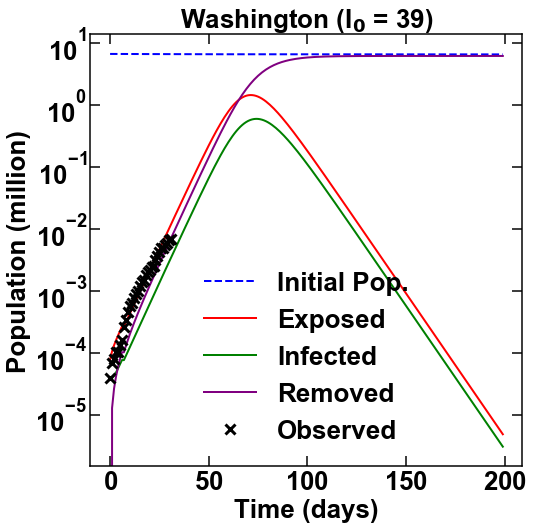

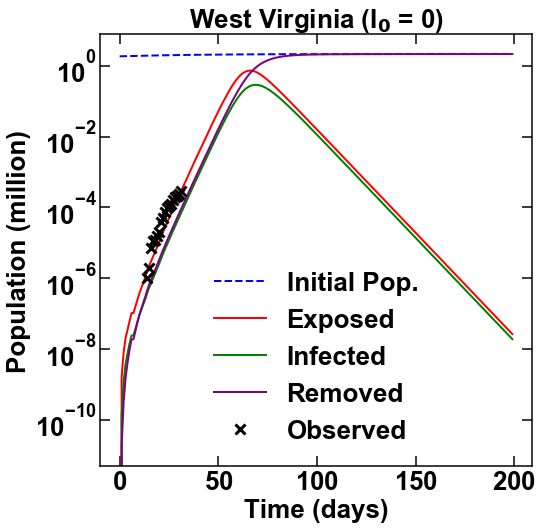

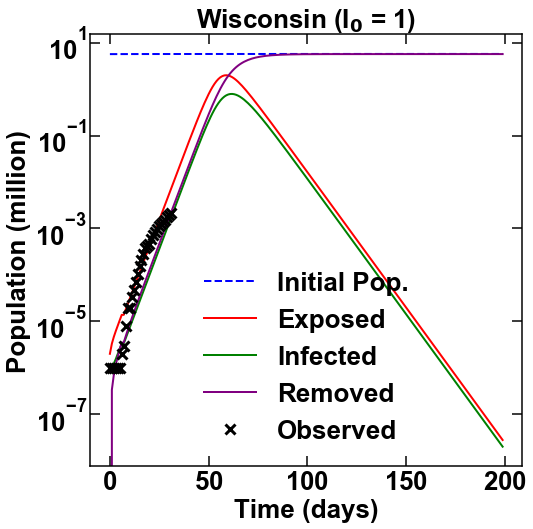

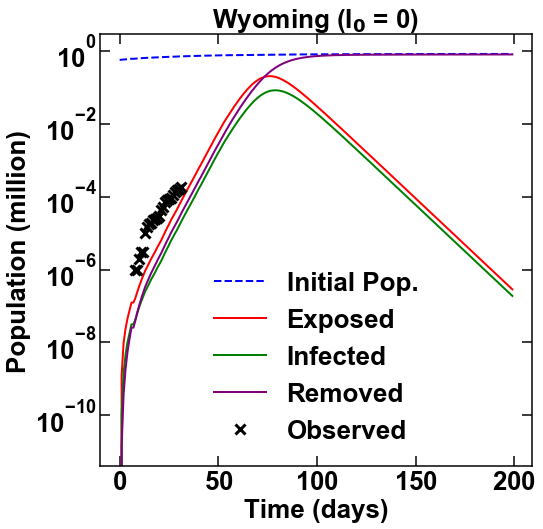

In [18]:
from cycler import cycler

def rename(name):
    l = [name[0]]
    for i in name[1:]:
        l += [i]
    return ''.join(l)

labels = ['Susceptible','Exposed','Infected','Removed','Deceased']

n1 = model.n_population*model.n_population
y1 = model.y.reshape(7,5,model.n_population,model.n_population).sum(axis=-1)

n2 = model1.n_population*model1.n_population
y2 = model1.y.reshape(193,5,model1.n_population,model1.n_population).sum(axis=-1)

n=n1+n2
y=numpy.concatenate((y1,y2), axis=0)

N_ = y[:,:4,:].sum(axis=1)
N = y[:,:,:].sum(axis=1)

plt.rcParams['figure.max_open_warning'] = 100
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['mathtext.bf'] = 'Arial'
plt.rcParams['axes.formatter.use_mathtext'] = True


from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif': ['Arial']})
rc('text', usetex=False)
def set_font(p,plt):
    for size in ['axes.titlesize','axes.labelsize','font.size','figure.titlesize','legend.fontsize','xtick.labelsize','ytick.labelsize']:
        plt.rcParams[size] = p

set_font(26,plt)


for i in range(model1.n_population):
    fig, [ax] = panel(1,1)
    ax.plot(N[:,i]/1e6,"--",label=r'Initial Pop.')
    for j in range(1,4):
        ax.plot(y[:,j,i]/1e6,label=r'{}'.format(labels[j]),) #**next(LS),**next(marker))

    y3 = no_of_cases[l2[i]][0]
    ax.plot(range(len(y3)),y3/1e6,'x',label=r'Observed',c='k',mew=3)

    ax.set_title(r"{}".format("{} (I$_0$ = {})".format(rename(l2[i]),y3[0])))
    ax.set_yscale('log')
    plt.xlabel('Time (days)')
    plt.ylabel('Population (million)')
    plt.minorticks_off()
    ax.legend()
    fig.savefig('./States/{}_pred.png'.format(l2[i]),bbox_inches = 'tight')
    fig.show()

